In [1]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
import arviz as az

import warnings
warnings.filterwarnings("ignore")

# Get Data

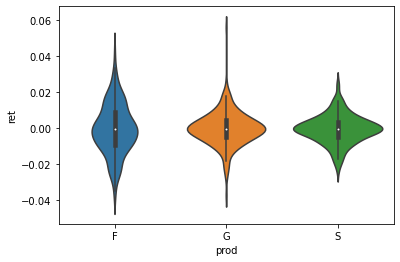

In [2]:
data = np.load("sample_data/fgs.npy" , allow_pickle = True).item()


# Combine Seperate DFs into one
combined_df = pd.DataFrame()
for k , v in data.items():
    # Create Returns and Directional Movement
    v["ret"] = v["close"].pct_change()
    v.dropna(axis = 0 , inplace = True)
    v["dir"] = v["ret"].apply(lambda x: 1 if x >= 0  else 0)
    v["prod"] = k
    combined_df = pd.concat([combined_df , v[["ret","dir","prod"]]] , axis = 0)
    
# Visualize Data
sns.violinplot(x='prod', y='ret', data=combined_df)

# Create Categories
ret_arr = combined_df['ret'].values
idx = pd.Categorical(combined_df['prod'],
                     categories=["F","G","S"]).codes
groups = len(np.unique(idx))

# Model With Groups`

## Normal

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu]
Sampling 2 chains, 0 divergences: 100%|██████████| 11000/11000 [00:47<00:00, 229.68draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1259b8a90>,
      dtype=object)

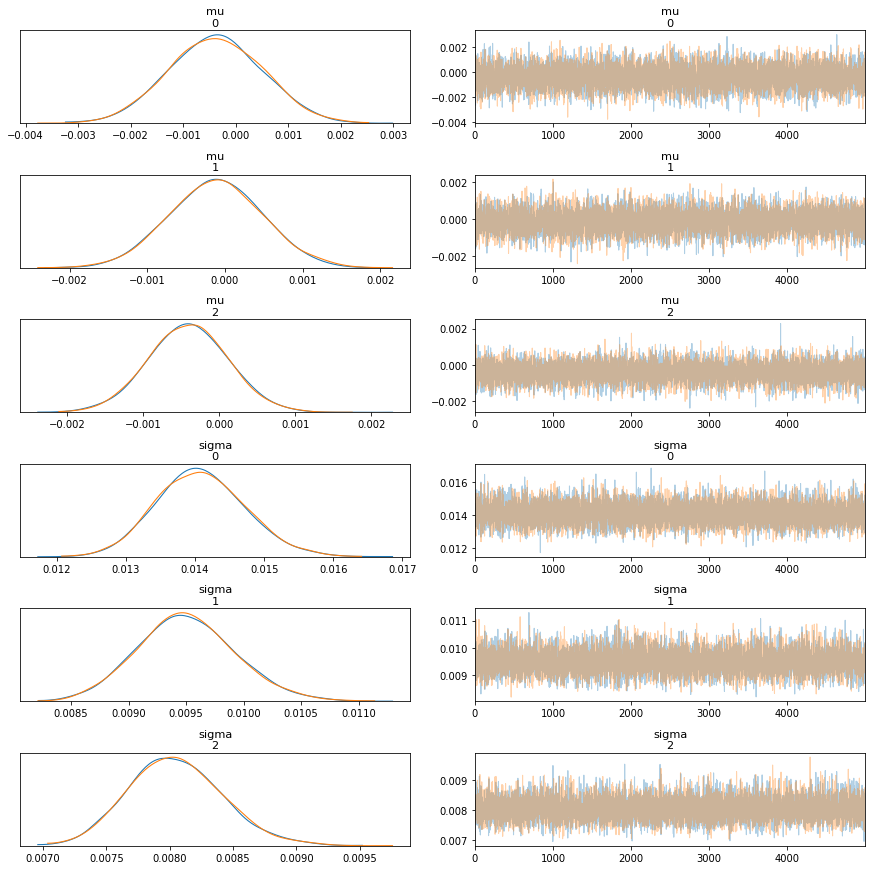

In [3]:
with pm.Model() as comparing_groups:
    mu = pm.Normal('mu', mu=0, sd=10, shape=groups)
    sigma = pm.HalfNormal('sigma', sd=10, shape=groups)

    y = pm.Normal('y', mu=mu[idx], sd=sigma[idx], observed = ret_arr)
    trace_cg = pm.sample(5000)
    
az.plot_trace(trace_cg)


In [4]:
def compare_diff(trace_: "trace of mcmc", i: "1st cat" , j:"2nd cat"):
    _, ax = plt.subplots(1, 1, figsize=(14, 8), constrained_layout=True)
    dist = stats.norm()
    diff_ = trace_["mu"][:, i] - trace_["mu"][:, j]
    d_cohen = (diff_ / np.sqrt((trace_["sigma"][:, i]**2 + trace_["sigma"][:, j]**2) / 2)).mean()
    ps = dist.cdf(d_cohen/(2**0.5))
    az.plot_posterior(diff_, ref_val=0, ax=ax)
    ax.set_title(f'$\mu_{i}-\mu_{j}$')
    ax.plot(0, label=f"Cohen's d = {d_cohen:.2f}\nProb sup = {ps:.2f}", alpha=0)
    ax.legend()

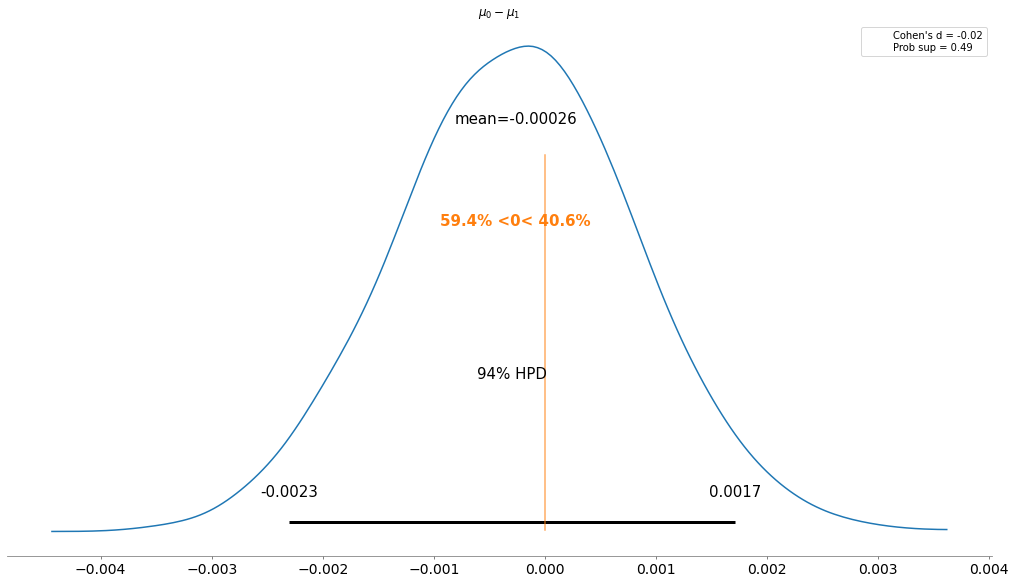

In [5]:
compare_diff(trace_cg, 0 , 1)

## Student T

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [dof, sigma, mu]
Sampling 2 chains, 0 divergences: 100%|██████████| 11000/11000 [01:47<00:00, 102.77draws/s]
The acceptance probability does not match the target. It is 0.8908498391275591, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8875841029808028, but should be close to 0.8. Try to increase the number of tuning steps.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1249da6d0>,
      dtype=object)

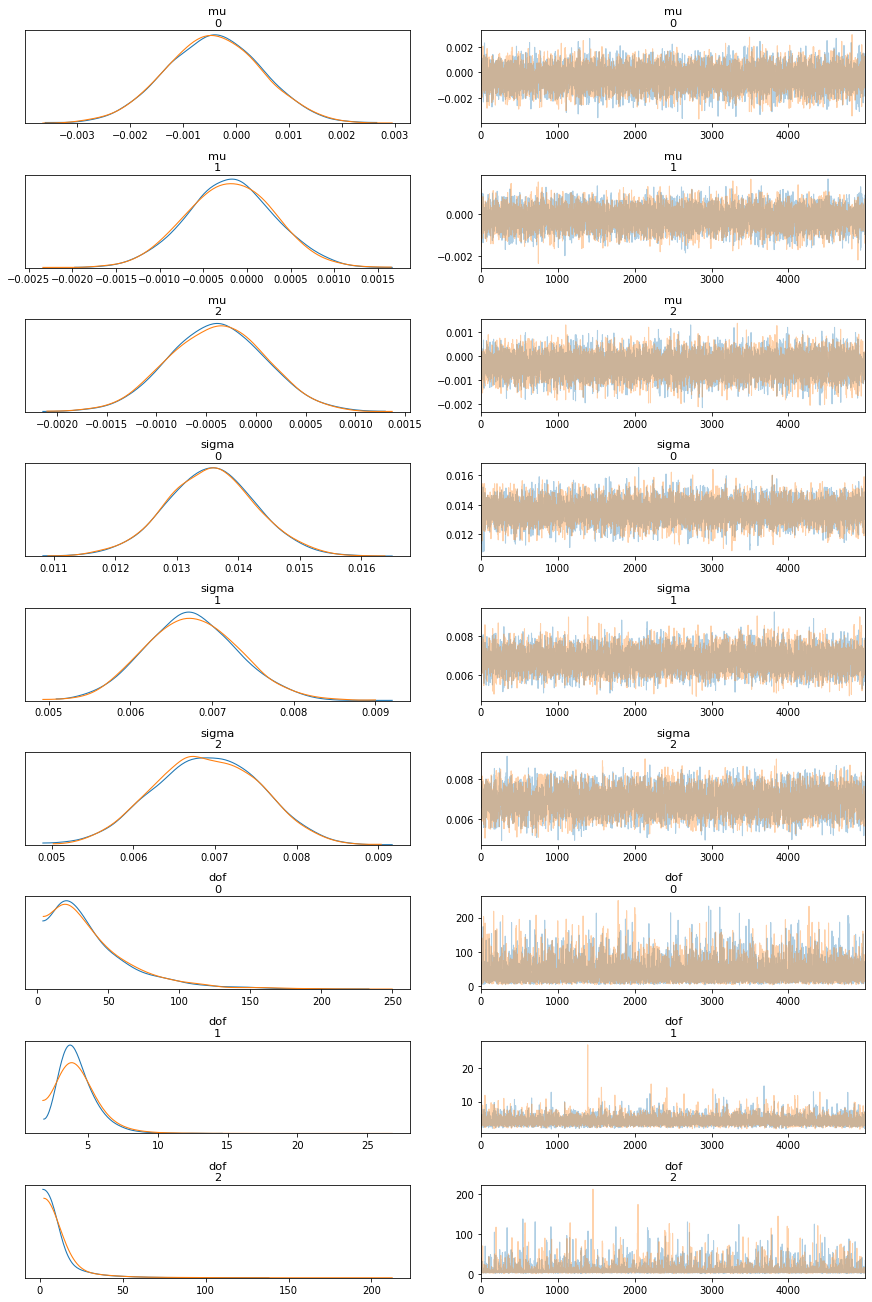

In [6]:
with pm.Model() as comparing_groups_t:
    mu = pm.Normal('mu', mu=0, sd=10, shape=groups)
    sigma = pm.HalfNormal('sigma', sd=10, shape=groups)
    dof = pm.Exponential('dof', 1/30, shape=groups)
    y = pm.StudentT('y', mu=mu[idx], sd=sigma[idx], nu=dof[idx] , observed = ret_arr)
    trace_cg_t = pm.sample(5000)
    
az.plot_trace(trace_cg_t)


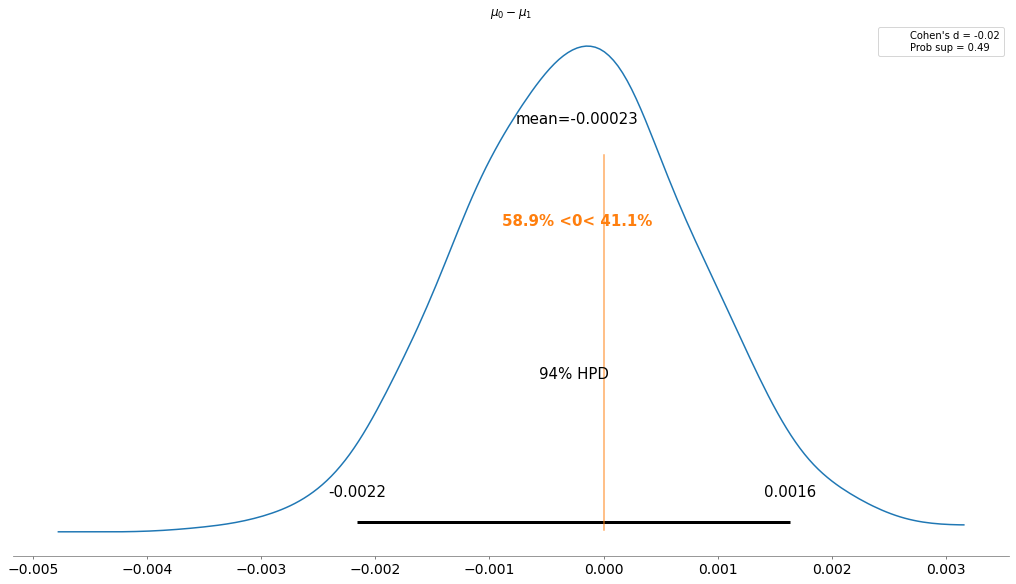

In [7]:
compare_diff(trace_cg_t, 0 , 1)

arviz.data.io_pymc3 - WARNING - posterior predictive variable y's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


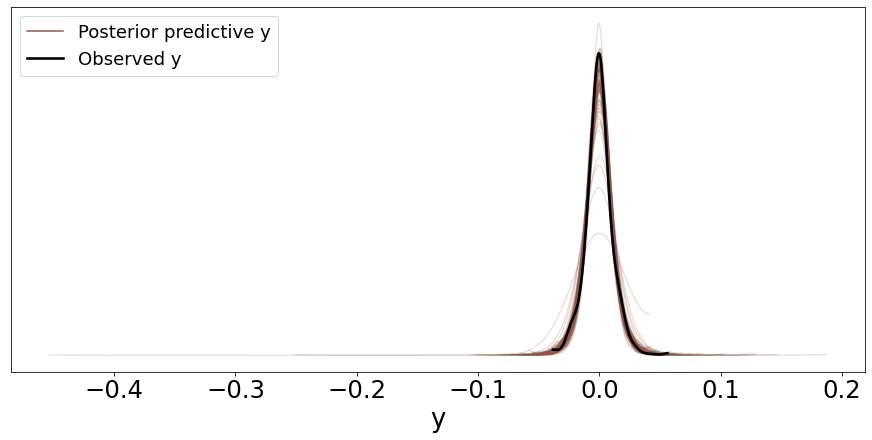

In [16]:
y_pred_t = pm.sample_posterior_predictive(trace_cg_t, 100, comparing_groups_t)
data_ppc = az.from_pymc3(trace=trace_cg_t, posterior_predictive=y_pred_t)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=False)

# Compare Gaussian and Student

In [9]:
display(az.summary(trace_cg))
display(az.summary(trace_cg_t))

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  \
mu[0]    -0.000  0.001  -0.002    0.001        0.0      0.0   12370.0   
mu[1]    -0.000  0.001  -0.001    0.001        0.0      0.0   11018.0   
mu[2]    -0.000  0.001  -0.001    0.001        0.0      0.0   10749.0   
sigma[0]  0.014  0.001   0.013    0.015        0.0      0.0   13815.0   
sigma[1]  0.010  0.000   0.009    0.010        0.0      0.0   10140.0   
sigma[2]  0.008  0.000   0.007    0.009        0.0      0.0   10623.0   

           ess_sd  ess_bulk  ess_tail  r_hat  
mu[0]      6604.0   12353.0    7842.0    1.0  
mu[1]      5617.0   11020.0    8054.0    1.0  
mu[2]      7608.0   10754.0    8051.0    1.0  
sigma[0]  13707.0   13898.0    8240.0    1.0  
sigma[1]  10054.0   10236.0    7451.0    1.0  
sigma[2]  10528.0   10743.0    8015.0    1.0

mean      sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  \
mu[0]     -0.000   0.001  -0.002    0.001      0.000    0.000   12513.0   
mu[1]     -0.000   0.000  -0.001    0.001      0.000    0.000   13572.0   
mu[2]     -0.000   0.000  -0.001    0.000      0.000    0.000   10143.0   
sigma[0]   0.014   0.001   0.012    0.015      0.000    0.000   10044.0   
sigma[1]   0.007   0.001   0.006    0.008      0.000    0.000    6758.0   
sigma[2]   0.007   0.001   0.006    0.008      0.000    0.000    5025.0   
dof[0]    40.466  30.696   4.745   95.606      0.321    0.240    9124.0   
dof[1]     4.324   1.389   2.188    6.703      0.018    0.014    5814.0   
dof[2]    12.095  13.468   2.100   33.530      0.201    0.142    4509.0   

           ess_sd  ess_bulk  ess_tail  r_hat  
mu[0]      5594.0   12521.0    7352.0    1.0  
mu[1]      5998.0   13568.0    8185.0    1.0  
mu[2]      6451.0   10128.0    7072.0    1.0  
sigma[0]  10028.0   10099.0    6730.0    1.0  
sigma[1]   6737.0    6769.0    7156.0    1.0  
sigma[2]   4984.0    5039.0    6889.0    1.0  
dof[0]     8188.0    8916.0    7589.0    1.0  
dof[1]     5036.0    6860.0    6131.0    1.0  
dof[2]     4509.0    5082.0    5239.0    1.0